<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Lab, we will build a VAE to generate new images of handwritten digits.

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 235 kB 9.9 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 78 kB 9.5 MB/s 
     |████████████████████████████████| 1.6 MB 52.1 MB/s 
     |████████████████████████████████| 51 kB 8.9 MB/s 


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        #encoder
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim) # mean vector
        self.d32 = nn.Linear(h_dim2, z_dim) # log_var vector
        #decoder
        self.d4 = nn.Linear(z_dim, h_dim2)        
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):#sampling from the encoder outputs (mean & log_var)
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean) # z = mean + eps*std
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [ ]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [ ]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [ ]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 2948.287	train_kld: 252.202	train_recon: 2696.084	train_log_var: -0.152	train_mean: -0.001	val_loss: 2357.468	val_kld: 463.584	val_recon: 1893.884	val_log_var: -0.268	val_mean: 0.002	(12.17s - 109.57s remaining)


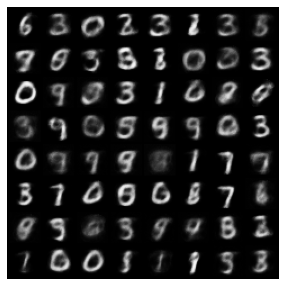

EPOCH: 2.000	train_loss: 2206.979	train_kld: 488.974	train_recon: 1718.004	train_log_var: -0.296	train_mean: 0.000	val_loss: 2098.625	val_kld: 520.889	val_recon: 1577.736	val_log_var: -0.314	val_mean: -0.006	(23.41s - 93.64s remaining)


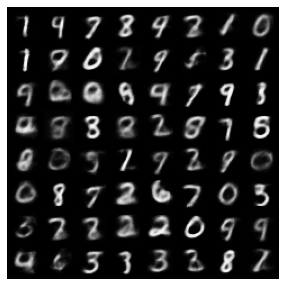

EPOCH: 3.000	train_loss: 2078.236	train_kld: 535.333	train_recon: 1542.903	train_log_var: -0.329	train_mean: 0.000	val_loss: 2018.627	val_kld: 561.420	val_recon: 1457.208	val_log_var: -0.345	val_mean: 0.003	(33.35s - 77.83s remaining)


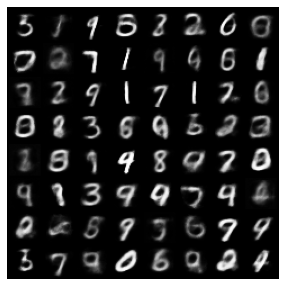

EPOCH: 4.000	train_loss: 2016.527	train_kld: 559.362	train_recon: 1457.165	train_log_var: -0.346	train_mean: -0.000	val_loss: 1978.401	val_kld: 586.169	val_recon: 1392.232	val_log_var: -0.362	val_mean: 0.003	(43.12s - 64.68s remaining)


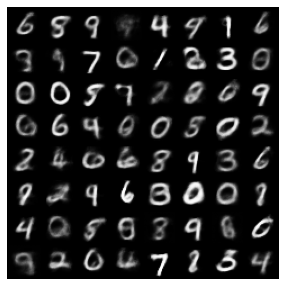

EPOCH: 5.000	train_loss: 1976.187	train_kld: 574.047	train_recon: 1402.140	train_log_var: -0.356	train_mean: -0.000	val_loss: 1945.051	val_kld: 588.315	val_recon: 1356.736	val_log_var: -0.367	val_mean: -0.003	(53.78s - 53.78s remaining)


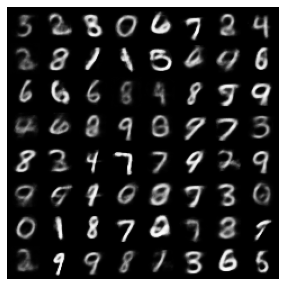

EPOCH: 6.000	train_loss: 1940.174	train_kld: 589.538	train_recon: 1350.636	train_log_var: -0.366	train_mean: -0.000	val_loss: 1910.648	val_kld: 598.586	val_recon: 1312.062	val_log_var: -0.374	val_mean: -0.001	(63.61s - 42.41s remaining)


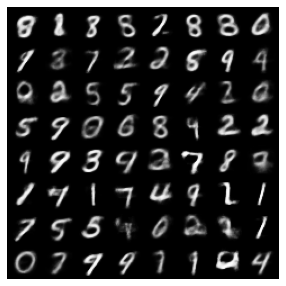

EPOCH: 7.000	train_loss: 1912.288	train_kld: 601.044	train_recon: 1311.244	train_log_var: -0.374	train_mean: -0.001	val_loss: 1891.139	val_kld: 609.768	val_recon: 1281.370	val_log_var: -0.380	val_mean: -0.008	(73.55s - 31.52s remaining)


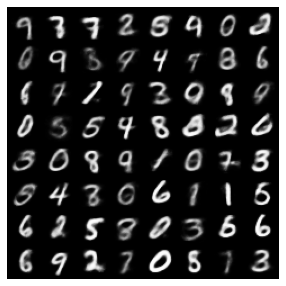

EPOCH: 8.000	train_loss: 1893.054	train_kld: 610.906	train_recon: 1282.148	train_log_var: -0.380	train_mean: -0.000	val_loss: 1874.567	val_kld: 617.038	val_recon: 1257.528	val_log_var: -0.384	val_mean: -0.001	(83.47s - 20.87s remaining)


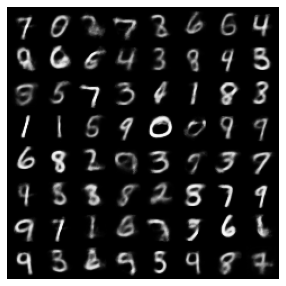

EPOCH: 9.000	train_loss: 1878.029	train_kld: 619.017	train_recon: 1259.013	train_log_var: -0.385	train_mean: -0.000	val_loss: 1863.007	val_kld: 627.393	val_recon: 1235.614	val_log_var: -0.390	val_mean: -0.001	(93.82s - 10.42s remaining)


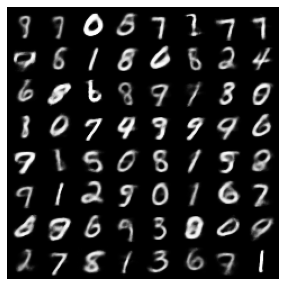

EPOCH: 10.000	train_loss: 1861.502	train_kld: 623.639	train_recon: 1237.863	train_log_var: -0.389	train_mean: -0.000	val_loss: 1856.824	val_kld: 610.510	val_recon: 1246.314	val_log_var: -0.384	val_mean: -0.002	(104.12s - 0.00s remaining)


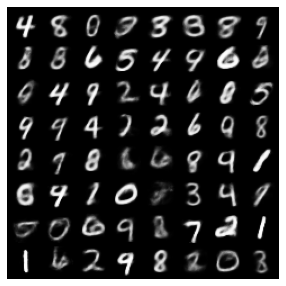

In [ ]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0) # The make_grid function plots images (and denormalizes them automatically, if required, before plotting).
        show(images)

We can see that we are able to generate realistic new images that were not present in the original image.

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:00<00:00, 532.74it/s]


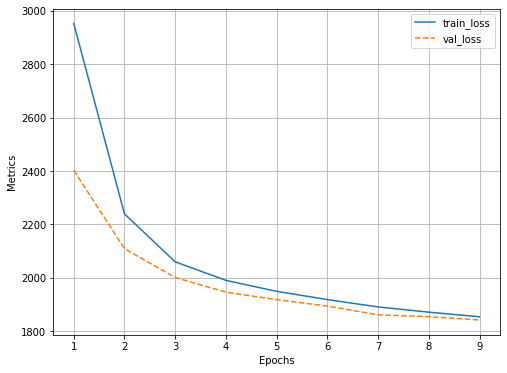

In [ ]:
log.plot_epochs(['train_loss','val_loss'])